In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
import keras
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.preprocessing import backend as K
from keras.models import Model
from keras import objectives
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import neighbors
from keras.models import model_from_json
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support,accuracy_score, cohen_kappa_score)

Using TensorFlow backend.


In [2]:
def load(digit,folder):
    path_to_data = 'data/mnist/'+ folder + '/' + str(digit) +'/'
    files = [file for file in os.listdir(path_to_data)]
    images = [cv2.imread(path_to_data + file, cv2.IMREAD_GRAYSCALE) for file in files]
    images = [cv2.resize(img, (28, 28)) for img in images if img is not None]
    labels = [digit]*len(images)
    return images, labels

In [3]:
train_x, train_y= [], []
for i in tqdm(range(10)):
    imgs = load(i,'training')
    train_x += imgs[0] 
    train_y += imgs[1]

In [4]:
train_x = np.array(train_x, dtype="float") / 255.0
image_size = train_x.shape[1]
train_x = train_x.reshape(-1,28,28,1)
train_y = np.array(train_y)

print(train_x.shape, train_y.shape)

(60000, 28, 28, 1) (60000,)


In [5]:
latent_dim = 10 # dimension of latent variable

inputs = Input(shape = (28,28,1))
conv1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(inputs)
conv1_1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(conv1)
pool1 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv1_1)
conv2 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv2)

flat = Flatten()(pool2)
input_to_z = Dense(32, activation = 'relu')(flat)
mu = Dense(latent_dim, name='mu')(input_to_z)
sigma = Dense(latent_dim, name='log_var')(input_to_z)

encoder = Model(inputs, mu)

def sampling(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape=(K.shape(mu)),
                              mean=0., stddev=1.)
    return mu + K.exp(sigma) * epsilon

z = Lambda(sampling,output_shape=(latent_dim,))([mu, sigma])

decoder_inputs = Input(K.int_shape(z)[1:])
dense_layer_d = Dense(7*7*32, activation = 'relu')(decoder_inputs)
output_from_z_d = Reshape((7,7,32))(dense_layer_d)
trans1_d = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(output_from_z_d)
trans1_1_d = Conv2DTranspose(16, 3, padding='same', activation='relu', strides=(2, 2))(trans1_d)
trans2_d = Conv2DTranspose(1, 3, padding='same', activation='relu')(trans1_1_d)

decoder = Model(decoder_inputs, trans2_d)
z_decoded = decoder(z)

vae = Model(inputs, z_decoded)
vae.summary()


class calc_output_with_los(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        kl_loss = -5e-4 * K.mean(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

outputs = calc_output_with_los()([inputs, z_decoded])

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 16)   2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 16)   0           conv2d_2[0][0]                   
_____________________________________

In [6]:
vae = Model(inputs, outputs)
m = 128
n_epoch = 100
vae.compile(optimizer='adam', loss=None)
vae_history = vae.fit(train_x, epochs=n_epoch, batch_size=m, shuffle=True,validation_split=0.1,
        callbacks = [EarlyStopping(monitor='val_loss',patience = 5)])

Instructions for updating:
Use tf.cast instead.
Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 90s 2ms/step - loss: 0.2484 - val_loss: 0.1813
Epoch 2/100
54000/54000 [==============================] - 89s 2ms/step - loss: 0.1909 - val_loss: 0.1663
Epoch 3/100
54000/54000 [==============================] - 90s 2ms/step - loss: 0.1677 - val_loss: 0.1638
Epoch 4/100
54000/54000 [==============================] - 91s 2ms/step - loss: 0.1830 - val_loss: 0.1590
Epoch 5/100
54000/54000 [==============================] - 88s 2ms/step - loss: 0.1628 - val_loss: 0.1604
Epoch 6/100
54000/54000 [==============================] - 88s 2ms/step - loss: 0.1728 - val_loss: 0.1563
Epoch 7/100
54000/54000 [==============================] - 88s 2ms/step - loss: 0.1763 - val_loss: 0.1654
Epoch 8/100
54000/54000 [==============================] - 87s 2ms/step - loss: 0.1760 - val_loss: 0.1558
Epoch 9/100
54000/54000 [==============================

In [8]:
model_json = vae.to_json()
with open("vae4.json", "w") as json_file:
    json_file.write(model_json)

vae.save_weights("vae4.h5")

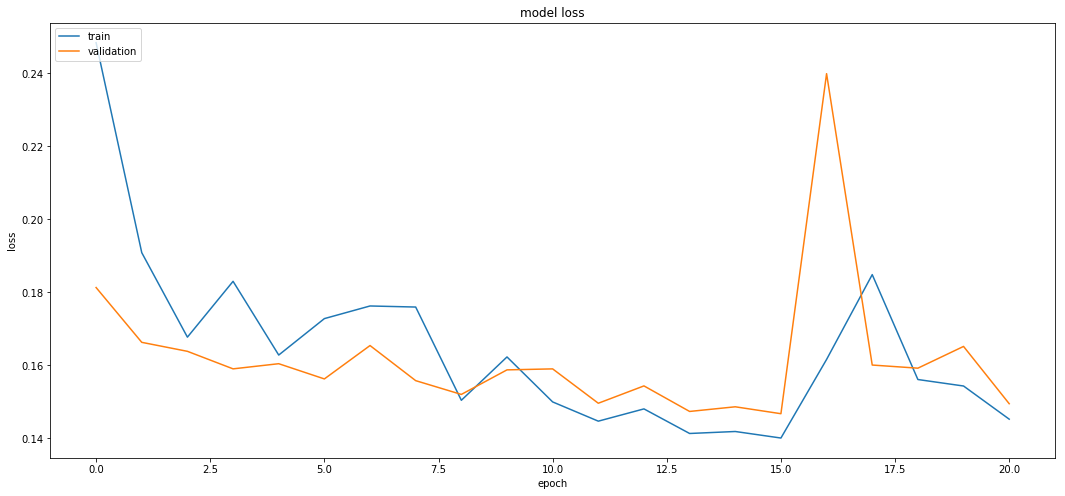

In [7]:
fig ,ax = plt.subplots(figsize=(18,8))
plt.plot(vae_history.history['loss'])
plt.plot(vae_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()    

In [9]:
train_x_encoded = encoder.predict(train_x)
weights='uniform'
n_neighbors=27
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(train_x_encoded, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=27, p=2,
           weights='uniform')

In [10]:
test_x, test_y= [], []
for i in tqdm(range(10)):
    test_x += load(i,'testing')[0] 
    test_y += load(i,'testing')[1]
test_x = np.array(test_x)
test_x = np.reshape(test_x, [-1, image_size, image_size, 1])
test_x = test_x.astype('float32') / 255
test_y = np.array(test_y)
print(test_x.shape, test_y.shape)


(10000, 28, 28, 1) (10000,)


In [11]:
test_x_encoded = encoder.predict(test_x)

test_x_neibghour = clf.predict(test_x_encoded)
print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
    accuracy_score(test_y, test_x_neibghour), 
    cohen_kappa_score(test_y, test_x_neibghour, weights="quadratic")))
print(' ')
print("Confusion Matrix:")
print(confusion_matrix(test_y, test_x_neibghour))
print("Classification Report:")
print(classification_report(test_y, test_x_neibghour))

Accuracy: 0.92100, Cohen's Kappa Score: 0.92011
 
Confusion Matrix:
[[ 963    0    2    2    0    4    4    1    4    0]
 [   1 1123    4    0    1    0    3    0    2    1]
 [   9    0  976   11    2    1    3    9   19    2]
 [   3    4    9  940    0   13    0    7   28    6]
 [   1    1    2    0  823    1   12    5    3  134]
 [   8    1    1   63    2  772   12    1   27    5]
 [   6    3    1    0    4    8  931    0    3    2]
 [   0   10   13    0    3    0    0  920    3   79]
 [  13    1   13   13   10   26    3    5  878   12]
 [   2    6    6   10   47   13    1   28   12  884]]
Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       980
          1       0.98      0.99      0.98      1135
          2       0.95      0.95      0.95      1032
          3       0.90      0.93      0.92      1010
          4       0.92      0.84      0.88       982
          5       0.92      0.87      0.89       892
      

In [19]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 30, criterion = 'entropy', random_state = 42)
classifier.fit(train_x_encoded, train_y)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [20]:
y_pred = classifier.predict(test_x_encoded) 

In [21]:
print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
    accuracy_score(test_y, y_pred), 
    cohen_kappa_score(test_y, y_pred, weights="quadratic")))
print(' ')
print("Confusion Matrix:")
print(confusion_matrix(test_y, y_pred))
print("Classification Report:")
print(classification_report(test_y, y_pred))

Accuracy: 0.91640, Cohen's Kappa Score: 0.91441
 
Confusion Matrix:
[[ 958    0    1    1    0    5   11    1    3    0]
 [   0 1116    5    3    2    0    5    1    2    1]
 [   8    0  975   17    4    1    3    8   16    0]
 [   9    3   14  934    0   16    0    9   19    6]
 [   0    1    4    0  872    1   12    5    6   81]
 [  13    0    3   49    4  787    8    1   26    1]
 [   7    2    3    0    5   14  925    0    2    0]
 [   0    4   19    2    5    0    0  932    1   65]
 [  14    3   18   35    9   31    2    5  843   14]
 [   2    5    4   12   96   11    1   41   15  822]]
Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       980
          1       0.98      0.98      0.98      1135
          2       0.93      0.94      0.94      1032
          3       0.89      0.92      0.91      1010
          4       0.87      0.89      0.88       982
          5       0.91      0.88      0.90       892
      